# Dependencies

In [5]:
from sys import path
path.append('src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from math import ceil
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from src.mrk_file import MRKFile
from src.iso_standard import PhotographicRequirements
from src.utils.plot import plot_confusion_matrix
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, Input

In [6]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_TRAIN_BOTTLENECKS = 'data/train_bottlenecks.pkl'

FILE_VAL_DUMP = 'data/val_dump.pkl'
FILE_VAL_BOTTLENECKS = 'data/val_bottlenecks.pkl'

INPUT_SHAPE = (224, 224, 3)

In [7]:
output_names = ['blurred', 
                'looking_away', 
                'ink_marked_creased', 
                'unnatural_skin_tone', 
                'too_dark_light', 
                'washed_out', 
                'pixelation', 
                'hair_across_eyes', 
                'eyes_closed', 
                'varied_background', 
                'roll_pitch_yaw', 
                'flash_reflection_on_skin', 
                'red_eyes', 
                'shadows_behind_head', 
                'shadows_across_face', 
                'dark_tinted_lenses', 
                'flash_reflection_on_lenses', 
                'frames_too_heavy', 
                'frame_covering_eyes', 
                'hat_cap', 
                'veil_over_face', 
                'mouth_open', 
                'presence_of_other_faces_or_toys']

# Helper Methods 

In [8]:
def load_proportions(file_txt):
    prop_values = np.loadtxt(file_txt)
    return pd.DataFrame(prop_values, index=output_names).T

def plot_graph(subplot, train, val, title):
    plt.subplot(*subplot)
    plt.plot(train, label='train')
    plt.plot(val, label='val')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()

def save_history(history, output_file):
    n_epochs = len(history['loss'])
    n_graphs = len(output_names) * 2
    n_cols = 2
    n_rows = ceil(n_graphs / n_cols)

    df_train_props = load_proportions('data/train_max_proportions.txt')
    df_val_props = load_proportions('data/val_max_proportions.txt')
    
    plt.figure(figsize=(16, 100))
    for i, name in zip(range(1, n_graphs, 2), output_names):
        train_loss = history[name + '_loss']
        train_acc = history[name + '_acc']
        val_loss = history['val_' + name + '_loss']
        val_acc = history['val_' + name + '_acc']

        plot_graph((n_rows, n_cols, i), train_loss, val_loss, '{} ({})'.format(name, 'loss'))
        plot_graph((n_rows, n_cols, i + 1), train_acc, val_acc, '{} ({})'.format(name, 'acc'))
        plt.hlines(df_train_props[name], 0, n_epochs, linestyle=':', color='blue')
        plt.hlines(df_val_props[name], 0, n_epochs, linestyle=':', color='orange')

    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()
    
def save_heatmaps(y_trues, y_preds, output_file, figsize=(20, 20)):
    plt.figure(figsize=figsize)

    n_graphs = len(output_names)
    n_cols = 5
    n_rows = ceil(n_graphs / n_cols)
    labels = np.unique(y_trues)

    for i, name, y_true, y_pred in zip(range(1, n_graphs + 1), output_names, y_trues, y_preds):
        y_pred = np.argmax(y_pred, axis=-1)
        conf_matrix = confusion_matrix(y_true.ravel(), y_pred, labels=labels)

        plt.subplot(n_rows, n_cols, i)
        plot_confusion_matrix(conf_matrix, 
                              target_names=['D', 'NC', 'C'], 
                              title=name, 
                              normalize=True)
    plt.savefig(output_file)
    plt.close()

# Load Data 

In [5]:
train_image_files, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))

print(len(train_image_files), type(train_image_files))
print(x_train.shape, x_train.dtype)
print(len(train_mrks), type(train_mrks[0]))

5211 <class 'list'>
(5211, 224, 224, 3) float32
5211 <class 'src.mrk_file.MRKFile'>


In [6]:
val_image_files, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))

print(len(val_image_files), type(val_image_files))
print(x_val.shape, x_val.dtype)
print(len(val_mrks), type(val_mrks[0]))

565 <class 'list'>
(565, 224, 224, 3) float32
565 <class 'src.mrk_file.MRKFile'>


# Save Bottlenecks 

In [7]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [8]:
train_features = base_model.predict(x_train, batch_size=32, verbose=1)
val_features = base_model.predict(x_val, batch_size=32, verbose=1)

print(train_features.shape, train_features.dtype)
print(val_features.shape, val_features.dtype)

565/565 [==============================] - 1s 1ms/step
(5211, 7, 7, 1024) float32
(565, 7, 7, 1024) float32


In [9]:
train_values = np.array([mrk.photo_reqs.values() for mrk in train_mrks], dtype=np.int8)
val_values = np.array([mrk.photo_reqs.values() for mrk in val_mrks], dtype=np.int8)

print(train_values.shape, train_values.dtype)
print(val_values.shape, val_values.dtype)

(5211, 23) int8
(565, 23) int8


In [10]:
pkl.dump((train_features, train_values), open(FILE_TRAIN_BOTTLENECKS, 'wb'), protocol=-1)
pkl.dump((val_features, val_values), open(FILE_VAL_BOTTLENECKS, 'wb'), protocol=-1)

# Transfer Learning 

In [9]:
train_features, train_values = pkl.load(open(FILE_TRAIN_BOTTLENECKS, 'rb'))
val_features, val_values = pkl.load(open(FILE_VAL_BOTTLENECKS, 'rb'))

print(train_features.shape, train_features.dtype)
print(train_values.shape, train_values.dtype)
print(val_features.shape, val_features.dtype)
print(val_values.shape, val_values.dtype)

(5211, 7, 7, 1024) float32
(5211, 23) int8
(565, 7, 7, 1024) float32
(565, 23) int8


In [10]:
# encode reqs values from [-1, 0, 1] => [0, 1, 2]
enc = LabelEncoder()
enc.fit(train_values.ravel())

y_train = enc.transform(train_values.ravel()).reshape(train_values.shape)
y_val = enc.transform(val_values.ravel()).reshape(val_values.shape)

assert(y_train.shape == train_values.shape)
assert(y_val.shape == val_values.shape)
assert(np.all(y_train == train_values + 1))
assert(np.all(y_val == val_values + 1))

In [43]:
df_train_props = load_proportions('data/train_max_proportions.txt')
df_val_props = load_proportions('data/val_max_proportions.txt')

df_props = pd.DataFrame(pd.concat((df_train_props.T, df_val_props.T), axis=1))
df_props.columns = ['train', 'val']
df_props

,train,val
blurred,0.830935,0.900885
looking_away,0.699290,0.755752
ink_marked_creased,0.954903,1.000000
unnatural_skin_tone,0.940127,0.709735
too_dark_light,0.942429,0.879646
washed_out,0.999040,0.939823
pixelation,0.930148,0.948673
hair_across_eyes,0.859912,0.915044
eyes_closed,0.792170,0.828319
varied_background,0.717713,0.582301


## Hat/cap 

In [17]:
HATCAP_INDEX = 19

In [18]:
inputs = Input(shape=train_features.shape[1:], name='inputs')
output = GlobalAveragePooling2D(name='avg_pool_hatcap')(inputs)
output = Dropout(rate=0.5, name='drop_hatcap')(output)
output = Dense(units=3, activation='softmax', name=output_names[HATCAP_INDEX])(output)

model = Model(inputs=inputs, 
              outputs=output, 
              name='hatcap')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 7, 7, 1024)        0         
_________________________________________________________________
avg_pool_hatcap (GlobalAvera (None, 1024)              0         
_________________________________________________________________
drop_hatcap (Dropout)        (None, 1024)              0         
_________________________________________________________________
hat_cap (Dense)              (None, 3)                 3075      
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________


Train on 5211 samples, validate on 565 samples
Epoch 1/30
5211/5211 [==============================] - ETA: 0s - loss: 0.2792 - acc: 0.8892- ETA: 0s - loss: 0.2894 - acc: 0. - 1s 199us/step - loss: 0.2797 - acc: 0.8898 - val_loss: 0.1823 - val_acc: 0.9398
Epoch 2/30
5211/5211 [==============================] - 1s 198us/step - loss: 0.2549 - acc: 0.9014 - val_loss: 0.1754 - val_acc: 0.9469
Epoch 3/30
5211/5211 [==============================] - 1s 198us/step - loss: 0.2481 - acc: 0.9060 - val_loss: 0.1610 - val_acc: 0.9451
Epoch 4/30
5211/5211 [==============================] - 1s 193us/step - loss: 0.2514 - acc: 0.9040 - val_loss: 0.1792 - val_acc: 0.9451
Epoch 5/30
5211/5211 [==============================] - 1s 200us/step - loss: 0.2442 - acc: 0.9056 - val_loss: 0.1579 - val_acc: 0.9522
Epoch 6/30
5211/5211 [==============================] - 1s 197us/step - loss: 0.2375 - acc: 0.9110 - val_loss: 0.1595 - val_acc: 0.9469
Epoch 7/30
5211/5211 [==============================] - ETA: 0s 

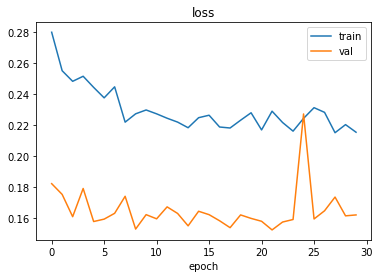

In [21]:
hist = model.fit(train_features, 
                 y_train[:, HATCAP_INDEX], 
                 batch_size=32, 
                 epochs=30, 
                 validation_data=(val_features, y_val[:, HATCAP_INDEX]), 
                 verbose=1)

plot_graph((1, 1, 1), hist.history['loss'], hist.history['val_loss'], 'loss')